**Результаты so far:**

*   Баланс классов в train/valid отличается (около 3%)
*   SOTA Accuracy на лидерборде = 0.61 (BERT)
*   Воспроизведен бейзлай RSG (Accuracy 0.45 на валидации)
*   Тюнинг параметров Tf-idf (Accuracy 0.49 на валидации) 
*   В конце ноутбука вынесены спорные вопросы о разметке 
*   Есть эвристика на сравнение количества общих лемм между ( choice1 и premise) VS (choice2 и premise) (Accuracy 0.54 на валидации)



# Data

In [1]:
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/tasks/download/PARus" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip
rm -r data/__MACOSX
rm -r sample_data/

In [10]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)

class JSONL_handler():
    """ opens a jsonl file and turns it into a necessary data structure """
    
    def __init__(self, path):
        self.path = path # path to jsonl file

    def to_pandas(self):
        """ get jsonl file content as a pandas DataFrame"""
        return pd.read_json(path_or_buf=self.path, lines=True)

In [11]:
train = JSONL_handler('data/PARus/train.jsonl')
train = train.to_pandas()

valid = JSONL_handler('data/PARus/val.jsonl')
valid = valid.to_pandas()

# Data Exploration

In [9]:
import matplotlib.pyplot as plt

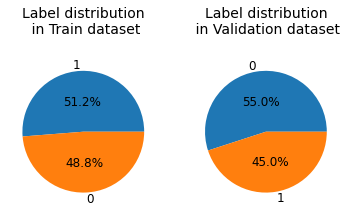

In [18]:
# Train/Valid Label Distribution 

plt.subplot(1,2,1)
plt.title('Label distribution\n in Train dataset\n', fontsize=14)
plt.pie(train['label'].value_counts(), 
        autopct="%.1f%%", 
        labels=train['label'].value_counts().keys(), pctdistance=0.5, 
        textprops = dict(fontsize = 12))

plt.subplot(1,2,2)
plt.title('Label distribution\n in Validation dataset\n', fontsize=14)
plt.pie(valid['label'].value_counts(), 
        autopct="%.1f%%", 
        labels=valid['label'].value_counts().keys(), pctdistance=0.5, 
        textprops = dict(fontsize = 12))
plt.show()

In [6]:
print(f"Train datasen contains {len(train)} samples.")
print(f"Valid dataset contains {len(valid)} samples.")

Train datasen contains 400 samples.
Valid dataset contains 100 samples.


# Preprocessing



*   Lemmatization (natasha)



In [7]:
%%capture
!pip install razdel
!pip install natasha

In [8]:
from natasha import (
    Segmenter,
    MorphVocab,  
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [9]:
def lemmatize(text):
    """
    param text: str
    return: List of lemmas (strings)
    """
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    lemmas = [token.lemma for token in doc.tokens]
    return lemmas

In [10]:
train['premise_lemmas'] = train.premise.apply(lemmatize)
train['choice1_lemmas'] = train.choice1.apply(lemmatize)
train['choice2_lemmas'] = train.choice2.apply(lemmatize)

valid['premise_lemmas'] = valid.premise.apply(lemmatize)
valid['choice1_lemmas'] = valid.choice1.apply(lemmatize)
valid['choice2_lemmas'] = valid.choice2.apply(lemmatize)

In [11]:
train.head()

,premise,choice1,choice2,question,label,idx,premise_lemmas,choice1_lemmas,choice2_lemmas
0,Моё тело отбрасывает тень на траву.,Солнце уже поднялось.,Трава уже подстрижена.,cause,0,0,"[мой, тело, отбрасывать, тень, на, трава, .]","[солнце, уже, подняться, .]","[трава, уже, подстричь, .]"
1,Женщина снисходительно относилась к странному поведению подруги.,"Женщина знала, что её подруга переживает трудные времена.","Женщина чувствовала, что подруга пользуется её добротой.",cause,0,1,"[женщина, снисходительно, относиться, к, странный, поведение, подруга, .]","[женщина, знать, ,, что, ее, подруга, переживать, трудный, время, .]","[женщина, чувствовать, ,, что, подруга, пользоваться, она, доброта, .]"
2,Женщины встретились попить кофе.,Их кафе открылось в новом месте.,Им хотелось пересечься друг с другом.,cause,1,2,"[женщина, встретиться, попить, кофе, .]","[их, кафе, открыться, в, новый, место, .]","[они, хотеться, пересечься, друг, с, друг, .]"
3,Бегунья была в шортах.,Прогноз обещал высокую температуру.,Она планировала бежать вдоль пляжа.,cause,0,3,"[бегунья, быть, в, шорты, .]","[прогноз, обещать, высокий, температура, .]","[она, планировать, бежать, вдоль, пляж, .]"
4,Гости вечеринки прятались за диваном.,Это была вечеринка-сюрприз.,Это был день рождения.,cause,0,4,"[гость, вечеринка, прятаться, за, диван, .]","[это, быть, вечеринка-сюрприз, .]","[это, быть, день, рождение, .]"


In [12]:
train_first = train[train['label']==0]
train_second = train[train['label']==1]



*   train_first - Датасет с label = 0
*   train_second - Датасет с label = 1



# Base Models

## RSG Baseline

In [13]:
%%capture
%%bash
wget -q --show-progress "https://russiansuperglue.com/tasks/tf_idf" -O temp.zip
unzip temp.zip -d data

In [21]:
import joblib
import codecs
import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [15]:
vect = joblib.load("data/tfidf.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [26]:
# taken from https://github.com/RussianNLP/RussianSuperGLUE/blob/master/tfidf_baseline/PARus.py
def build_feature_PARus(row):
    premise = str(row["premise"]).strip()
    choice1 = row["choice1"]
    choice2 = row["choice2"]
    label = row.get("label")
    question = "Что было ПРИЧИНОЙ этого?" if row["question"] == "cause" else "Что случилось в РЕЗУЛЬТАТЕ?"
    res = f"{premise} {question} {choice1} {choice2}"
    return res, label


def build_features_PARus(path, vect):
    with codecs.open(path, encoding='utf-8-sig') as reader:
        lines = reader.read().split("\n")
        lines = list(map(json.loads, filter(None, lines)))
    res = list(map(build_feature_PARus, lines))
    texts = list(map(lambda x: x[0], res))
    labels = list(map(lambda x: x[1], res))
    ids = [x["idx"] for x in lines]
    return (vect.transform(texts), labels), ids


def fit_PARus(train, labels):
    clf = LogisticRegression()
    return clf.fit(train, labels)


def eval_PARus(train_path, val_path, test_path, vect):
    train, _ = build_features_PARus(train_path, vect)
    val, _ = build_features_PARus(val_path, vect)
    test, ids = build_features_PARus(test_path, vect)
    clf = fit_PARus(*train)
    try:
        test_score = clf.score(*test)
    except ValueError:
        test_score = None
    val_pred = clf.predict(val[0])
    print(classification_report(val[1], val_pred))
    return clf, {
        "train": clf.score(*train),
        "val": clf.score(*val),
        "test": test_score,
    }


train_path = "data/PARus/train.jsonl"
val_path = "data/PARus/val.jsonl"
test_path = "data/PARus/test.jsonl"

_, PARus_scores = eval_PARus(train_path, val_path, test_path, vect)
train_scr = PARus_scores['train']
valid_scr = PARus_scores['val']


print(f"Accuracy Score on Train: {train_scr}") # should be around 0.775

print(f"Accuracy Score on Valid: {valid_scr}") # should be around 0.45

              precision    recall  f1-score   support

           0       0.49      0.40      0.44        55
           1       0.40      0.49      0.44        45

    accuracy                           0.44       100
   macro avg       0.44      0.44      0.44       100
weighted avg       0.45      0.44      0.44       100

Accuracy Score on Train: 0.7725
Accuracy Score on Valid: 0.44


## Modified

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [28]:
# concatenate columns 

def build_feature_PARus(row):
    premise = str(row["premise"]).strip()
    choice1 = row["choice1"]
    choice2 = row["choice2"]
    label = row.get("label")
    question = "Что было ПРИЧИНОЙ этого?" if row["question"] == "cause" else "Что случилось в РЕЗУЛЬТАТЕ?"
    res = f"{premise} {question} {choice1} {choice2}"
    return res


train_concat = []
for i, row in train.iterrows():
    train_concat.append(build_feature_PARus(row))
train['concatenated'] = train_concat

valid_concat = []
for i, row in valid.iterrows():
    valid_concat.append(build_feature_PARus(row))
valid['concatenated'] =  valid_concat

In [29]:
train.head(2)

,premise,choice1,choice2,question,label,idx,premise_lemmas,choice1_lemmas,choice2_lemmas,concatenated
0,Моё тело отбрасывает тень на траву.,Солнце уже поднялось.,Трава уже подстрижена.,cause,0,0,"[мой, тело, отбрасывать, тень, на, трава, .]","[солнце, уже, подняться, .]","[трава, уже, подстричь, .]",Моё тело отбрасывает тень на траву. Что было ПРИЧИНОЙ этого? Солнце уже поднялось. Трава уже подстрижена.
1,Женщина снисходительно относилась к странному поведению подруги.,"Женщина знала, что её подруга переживает трудные времена.","Женщина чувствовала, что подруга пользуется её добротой.",cause,0,1,"[женщина, снисходительно, относиться, к, странный, поведение, подруга, .]","[женщина, знать, ,, что, ее, подруга, переживать, трудный, время, .]","[женщина, чувствовать, ,, что, подруга, пользоваться, она, доброта, .]","Женщина снисходительно относилась к странному поведению подруги. Что было ПРИЧИНОЙ этого? Женщина знала, что её подруга переживает трудные времена. Женщина чувствовала, что подруга пользуется её добротой."


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

steps = [('tfidf', TfidfVectorizer()),
         ('logreg', LogisticRegression(class_weight='balanced'))]

parameters = {'logreg__C': np.arange(0.0000000001, 1),
              'tfidf__min_df': np.arange(0.01, 0.1, 0.01),
              'tfidf__max_df': np.arange(0.6 , 1.0, 0.1),
              'tfidf__ngram_range': [(1,2), (1,3)],
              'tfidf__analyzer': ['char_wb', 'word']
              }

X_train = train.concatenated
X_test = valid.concatenated

y_train = train.label
y_test = valid.label

pipeline = Pipeline(steps)

search = GridSearchCV(pipeline, cv=3, param_grid = parameters)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

print("Accuracy: {}".format(search.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(search.best_params_))

Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.54      0.45      0.50        55
           1       0.44      0.53      0.48        45

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.50      0.49      0.49       100

Tuned Model Parameters: {'logreg__C': 1e-10, 'tfidf__analyzer': 'word', 'tfidf__max_df': 0.6, 'tfidf__min_df': 0.04, 'tfidf__ngram_range': (1, 2)}


# Heruistics

## Vocab Overlap

In [4]:
import numpy as np
from natasha import (
    Segmenter,
    MorphVocab,  
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

from base import BaseSolver

class ParusSolver(BaseSolver):
   
    def __init__(self, path: str, path_valid=None):
        super(ParusSolver, self).__init__(path, path_valid)
   
    def preprocess(self, columns):

        for column in columns:
            self.train[f"{column}_lemmas"] = self.train[column].apply(self.lemmatize)
            self.valid[f"{column}_lemmas"] = self.valid[column].apply(self.lemmatize)

    def lemmatize(self, text):
        """
        param text: str
        return: List of lemmas (strings)
        """

        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)

        for token in doc.tokens:
            token.lemmatize(morph_vocab)
        lemmas = [token.lemma for token in doc.tokens]
        return lemmas

    
    def heruistic_vocab_overlap(self, final_desicion=None):
        """
        This heruistic chooses the option that has more common lemmas with premise
        If the amount of common words is equal for both choices, it uses {final_desicion}
        function (one of BaseSolver functions) to predict
        param: final_decision (function)
        """
        y_true = self.valid.label
        y_pred = []
        self.preprocess(columns=['premise', 'choice1', 'choice2'])

        for i, row in self.valid.iterrows():
            words1 = set(row.choice1_lemmas)
            words2 = set(row.choice2_lemmas)
            premise = set(row.premise_lemmas)
            overlap1 = len(premise & words1)
            overlap2 = len(premise & words2)
            if overlap1 > overlap2:
                y_pred.append(0)
            elif overlap2 > overlap1:
                y_pred.append(1)
            else:
                y_pred.append(final_desicion(test_size=1)[0])
        self.show_report(y_true, y_pred)

In [5]:
# Vocab Overlap + Majority class
solver = ParusSolver(path='data/PARus/train.jsonl',
                     path_valid='data/PARus/val.jsonl')
solver.heruistic_vocab_overlap(final_desicion=solver.majority_class)

              precision    recall  f1-score   support

           0       0.60      0.16      0.26        55
           1       0.46      0.87      0.60        45

    accuracy                           0.48       100
   macro avg       0.53      0.52      0.43       100
weighted avg       0.54      0.48      0.41       100



In [6]:
# Vocab Overlap + Random Choice
solver = ParusSolver(path='data/PARus/train.jsonl',
                     path_valid='data/PARus/val.jsonl')
solver.heruistic_vocab_overlap(final_desicion=solver.random_choice)

              precision    recall  f1-score   support

           0       0.55      0.89      0.68        55
           1       0.45      0.11      0.18        45

    accuracy                           0.54       100
   macro avg       0.50      0.50      0.43       100
weighted avg       0.51      0.54      0.45       100



In [7]:
# Vocab Overlap + Random (balanced) Choice
solver = ParusSolver(path='data/PARus/train.jsonl',
                     path_valid='data/PARus/val.jsonl')
solver.heruistic_vocab_overlap(final_desicion=solver.random_balanced_choice)

              precision    recall  f1-score   support

           0       0.60      0.16      0.26        55
           1       0.46      0.87      0.60        45

    accuracy                           0.48       100
   macro avg       0.53      0.52      0.43       100
weighted avg       0.54      0.48      0.41       100



# Samples with questionable  markup

In [22]:
train.iloc[[3, 5, 15, 23, 30, 32, 35, 49, 54, 88, 119, 135]][['premise', 'choice1', 'choice2', 'question', 'label']]

,premise,choice1,choice2,question,label
3,Бегунья была в шортах.,Прогноз обещал высокую температуру.,Она планировала бежать вдоль пляжа.,cause,0
5,Политик проиграл выборы.,Он использовал плохие лозунги.,Никто не голосовал за него.,cause,1
15,Девушка ахнула.,Её друг пустил кубик льда вниз по её спине.,Её друг погладил её по спине.,cause,0
23,Хозяйка отменила праздник.,"Ей показалось, что у неё грипп.","Она переживала, что может подхватить грипп.",cause,0
30,Женщина напевала про себя.,Она нервничала.,Она была в хорошем настроении.,cause,1
32,Полицейские направили оружие на беглеца.,Беглец упал на землю.,Беглец бросил ружьё.,effect,1
35,Человек сразу вскочил с постели.,Он хотел выключить будильник.,Он хотел погладить брюки перед работой.,cause,0
49,Дети опрокинули лампу.,У них был бой подушками.,Они прыгали на кровати.,cause,0
54,Человек подписал документ.,Сделка была аннулирована.,Сделка стала официальной.,effect,1
88,Мужчина закрыл книгу.,Он закончил её читать.,Она заставила его задуматься.,cause,0
